In [1]:
print("hello")

hello


In [2]:
import time
from pprint import pprint
from IPython.display import display
from glob import glob
import re
import math
print("hello1")
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print("hello2")
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
print("hello3")
import torch
torch.set_default_dtype(torch.float64)
print("hello4")
import e3nn
print("hello5")
import e3nn.point.data_helpers as dh 
from training_utils import *
from variable_networks import VariableParityNetwork
print("bye")

hello1
hello2
hello3
hello4
hello5
bye


In [3]:
# make sure CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.version.cuda)
#print(torch.cuda.memory_summary())
device = "cuda"
#torch.rand(10).to(device)
#torch.rand(10, device=device)

0
1
Tesla V100-PCIE-32GB
True
10.1


In [4]:
# all expected elements
all_elements = ['C', 'H', 'N', 'O', 'S']
n_elements = len(all_elements)

# so we can normalize training data for the nuclei to be predicted
elementwide_scaling_factors = { "C" : (118.0, 51.0),    # element : (mean, stdev)
                                "H" : (29.0, 2.0)  }
relevant_elements = list(elementwide_scaling_factors.keys())

# irrelevant atoms will not be scaled
for element in all_elements:
    if element not in elementwide_scaling_factors:
        elementwide_scaling_factors[element] = (0.0,1.0)

In [5]:
# create a function to noramlize the shieldings for a specific molecule
# shielding -> (shielding-mean)/stdev or 0 if not a relevant element
def get_scalings(atomic_symbols):
    scaling_factors = [ elementwide_scaling_factors[a] for a in atomic_symbols ]
    scaling_factors = np.array(scaling_factors)
    def scaling_function(x):
        result = x - scaling_factors[:,0]
        result = result / scaling_factors[:,1]
        return result
    return scaling_factors, scaling_function
    
# generates one-hots for a list of atomic_symbols
def get_one_hots(atomic_symbols):
    one_hots = []
    for symbol in atomic_symbols:
        inner_list = [ 1. if symbol == i else 0. for i in all_elements ]
        one_hots.append(inner_list)
    return np.array(one_hots)

# compute weights for loss function
def get_weights(atomic_symbols, symmetrical_atoms):
    weights = [ 1.0 if symbol in relevant_elements else 0.0 for symbol in atomic_symbols ]
    weights = np.array(weights)
    for l in symmetrical_atoms:
        weight = 1.0/len(l)
        for i in l:
            weights[i] = weight
    return weights

In [6]:
# represents the training data for one molecule
# all of these items are stored on the cpu
class Molecule():
    def __init__(self, name,               
                 atomic_symbols,           
                 symmetrical_atoms,        # list of lists of 0-indexed atom numbers
                 perturbed_geometries,               
                 stationary_shieldings,
                 perturbed_shieldings):    
        self.name = name                                                     # name of molecule
        self.atomic_symbols = atomic_symbols                                 # vector of strings of length n_atoms
        self.n_atoms = len(atomic_symbols)                                   # number of atoms
        self.perturbed_geometries = perturbed_geometries                     # (n_examples, n_atoms, 3)
        self.stationary_shieldings = stationary_shieldings                   # (n_examples, n_atoms, 1)
        
        scaling_factors, scaling_function = get_scalings(atomic_symbols)
        self.scaling_factors = scaling_factors                               # (n_atoms, 2) inner axis is mean, stdev
        self.scaling_function = scaling_function                             # unscaled shieldings --> scaled shieldings 

        # scale perturbed shieldings and zero out data for irrelevant atoms
        perturbed_shieldings = self.scaling_function(perturbed_shieldings)
        for i,a in enumerate(atomic_symbols):
            if a not in relevant_elements:
                perturbed_shieldings[:,i]=0.0
        self.perturbed_shieldings = perturbed_shieldings                     # (n_examples, n_atoms, 1)
        
        self.features = get_one_hots(atomic_symbols)                         # (n_atoms, n_elements)
        self.weights = get_weights(atomic_symbols, symmetrical_atoms)        # (n_atoms,)

In [13]:
with h5py.File("qm7_big.hdf5", "r") as h5:
    for dataset_name,geometries_and_shieldings in h5.items():
        if not dataset_name.startswith("data_"):
            continue
        dataset_number = dataset_name.split("_")[1]
        geometries_and_shieldings = np.array(geometries_and_shieldings)
        stationary_shieldings = h5.attrs[f"stationary_{dataset_number}"]
        atomic_symbols = h5.attrs[f"atomic_symbols_{dataset_number}"]
        print(f"{dataset_name}\t{np.shape(geometries_and_shieldings)}\t{len(stationary_shieldings)}\t{len(atomic_symbols)}\t", end='')
        if np.shape(geometries_and_shieldings)[1] != len(stationary_shieldings) or \
           len(stationary_shieldings) != len(atomic_symbols) or \
           np.shape(geometries_and_shieldings)[1] != len(atomic_symbols):
            print("mismatch",end='')
        print()

data_000000	(100, 11, 4)	5	5	mismatch
data_000001	(100, 22, 4)	8	8	mismatch
data_000002	(100, 19, 4)	6	6	mismatch
data_000003	(100, 23, 4)	4	4	mismatch
data_000004	(100, 9, 4)	9	9	
data_000005	(100, 7, 4)	7	7	
data_000006	(100, 9, 4)	9	9	
data_000007	(100, 9, 4)	9	9	
data_000008	(100, 11, 4)	11	11	
data_000009	(100, 9, 4)	9	9	
data_000010	(100, 7, 4)	7	7	
data_000011	(100, 8, 4)	8	8	
data_000012	(100, 10, 4)	10	10	
data_000013	(100, 6, 4)	6	6	
data_000014	(100, 10, 4)	10	10	
data_000015	(100, 7, 4)	7	7	
data_000016	(100, 10, 4)	10	10	
data_000017	(100, 12, 4)	12	12	
data_000018	(100, 10, 4)	10	10	
data_000019	(100, 11, 4)	11	11	
data_000020	(100, 11, 4)	11	11	
data_000021	(100, 13, 4)	13	13	
data_000022	(100, 7, 4)	7	7	
data_000023	(100, 5, 4)	5	5	
data_000024	(100, 13, 4)	13	13	
data_000025	(100, 9, 4)	9	9	
data_000026	(100, 12, 4)	12	12	
data_000027	(100, 13, 4)	13	13	
data_000028	(100, 11, 4)	11	11	
data_000029	(100, 13, 4)	13	13	
data_000030	(100, 11, 4)	11	11	
data_000031	(100, 11

data_000345	(100, 13, 4)	13	13	
data_000346	(100, 19, 4)	19	19	
data_000347	(100, 17, 4)	17	17	
data_000348	(100, 13, 4)	13	13	
data_000349	(100, 14, 4)	14	14	
data_000350	(100, 19, 4)	19	19	
data_000351	(100, 15, 4)	15	15	
data_000352	(100, 19, 4)	19	19	
data_000353	(100, 15, 4)	15	15	
data_000354	(100, 11, 4)	11	11	
data_000355	(100, 15, 4)	15	15	
data_000356	(100, 15, 4)	15	15	
data_000357	(100, 11, 4)	11	11	
data_000361	(100, 17, 4)	17	17	
data_000364	(100, 19, 4)	19	19	
data_000367	(100, 11, 4)	11	11	
data_000368	(100, 19, 4)	19	19	
data_000369	(100, 15, 4)	15	15	
data_000374	(100, 14, 4)	14	14	
data_000376	(100, 14, 4)	14	14	
data_000378	(100, 16, 4)	16	16	
data_000379	(100, 16, 4)	16	16	
data_000380	(100, 12, 4)	12	12	
data_000381	(100, 12, 4)	12	12	
data_000385	(100, 16, 4)	16	16	
data_000387	(100, 15, 4)	15	15	
data_000391	(100, 17, 4)	17	17	
data_000395	(100, 17, 4)	17	17	
data_000400	(100, 19, 4)	19	19	
data_000401	(100, 8, 4)	8	8	
data_000402	(100, 14, 4)	14	14	
data_000403

data_000733	(100, 10, 4)	10	10	
data_000734	(100, 14, 4)	14	14	
data_000735	(100, 14, 4)	14	14	
data_000736	(100, 14, 4)	14	14	
data_000737	(100, 8, 4)	8	8	
data_000738	(100, 12, 4)	12	12	
data_000739	(100, 16, 4)	16	16	
data_000740	(100, 14, 4)	14	14	
data_000741	(100, 16, 4)	16	16	
data_000742	(100, 16, 4)	16	16	
data_000743	(100, 14, 4)	14	14	
data_000744	(100, 16, 4)	16	16	
data_000745	(100, 14, 4)	14	14	
data_000746	(100, 12, 4)	12	12	
data_000747	(100, 18, 4)	18	18	
data_000748	(100, 12, 4)	12	12	
data_000749	(100, 16, 4)	16	16	
data_000750	(100, 14, 4)	14	14	
data_000751	(100, 16, 4)	16	16	
data_000752	(100, 10, 4)	10	10	
data_000753	(100, 10, 4)	10	10	
data_000754	(100, 12, 4)	12	12	
data_000755	(100, 12, 4)	12	12	
data_000756	(100, 12, 4)	12	12	
data_000757	(100, 12, 4)	12	12	
data_000761	(100, 14, 4)	14	14	
data_000764	(100, 14, 4)	14	14	
data_000767	(100, 14, 4)	14	14	
data_000768	(100, 14, 4)	14	14	
data_000769	(100, 14, 4)	14	14	
data_000774	(100, 14, 4)	14	14	
data_000776

data_001102	(100, 11, 4)	11	11	
data_001103	(100, 18, 4)	18	18	
data_001104	(100, 18, 4)	18	18	
data_001105	(100, 11, 4)	11	11	
data_001106	(100, 13, 4)	13	13	
data_001107	(100, 9, 4)	9	9	
data_001108	(100, 11, 4)	11	11	
data_001109	(100, 11, 4)	11	11	
data_001110	(100, 15, 4)	15	15	
data_001111	(100, 13, 4)	13	13	
data_001112	(100, 9, 4)	9	9	
data_001113	(100, 11, 4)	11	11	
data_001114	(100, 11, 4)	11	11	
data_001115	(100, 16, 4)	16	16	
data_001116	(100, 15, 4)	15	15	
data_001117	(100, 13, 4)	13	13	
data_001118	(100, 15, 4)	15	15	
data_001119	(100, 13, 4)	13	13	
data_001120	(100, 15, 4)	15	15	
data_001121	(100, 13, 4)	13	13	
data_001122	(100, 7, 4)	7	7	
data_001123	(100, 9, 4)	9	9	
data_001124	(100, 7, 4)	7	7	
data_001125	(100, 11, 4)	11	11	
data_001126	(100, 14, 4)	14	14	
data_001127	(100, 11, 4)	11	11	
data_001128	(100, 9, 4)	9	9	
data_001129	(100, 11, 4)	11	11	
data_001130	(100, 11, 4)	11	11	
data_001131	(100, 9, 4)	9	9	
data_001132	(100, 13, 4)	13	13	
data_001133	(100, 15, 4)	15	1

data_001447	(100, 21, 4)	21	21	
data_001448	(100, 17, 4)	17	17	
data_001449	(100, 19, 4)	19	19	
data_001450	(100, 19, 4)	19	19	
data_001451	(100, 17, 4)	17	17	
data_001452	(100, 15, 4)	15	15	
data_001453	(100, 19, 4)	19	19	
data_001454	(100, 19, 4)	19	19	
data_001455	(100, 20, 4)	20	20	
data_001456	(100, 18, 4)	18	18	
data_001457	(100, 16, 4)	16	16	
data_001461	(100, 20, 4)	20	20	
data_001464	(100, 20, 4)	20	20	
data_001467	(100, 20, 4)	20	20	
data_001468	(100, 15, 4)	15	15	
data_001469	(100, 13, 4)	13	13	
data_001474	(100, 19, 4)	19	19	
data_001476	(100, 17, 4)	17	17	
data_001478	(100, 20, 4)	20	20	
data_001479	(100, 19, 4)	19	19	
data_001480	(100, 19, 4)	19	19	
data_001481	(100, 20, 4)	20	20	
data_001485	(100, 19, 4)	19	19	
data_001487	(100, 19, 4)	19	19	
data_001491	(100, 19, 4)	19	19	
data_001495	(100, 20, 4)	20	20	
data_001500	(100, 18, 4)	18	18	
data_001501	(100, 16, 4)	16	16	
data_001502	(100, 14, 4)	14	14	
data_001503	(100, 20, 4)	20	20	
data_001504	(100, 18, 4)	18	18	
data_001

data_001829	(100, 19, 4)	19	19	
data_001830	(100, 17, 4)	17	17	
data_001831	(100, 19, 4)	19	19	
data_001832	(100, 19, 4)	19	19	
data_001833	(100, 15, 4)	15	15	
data_001834	(100, 17, 4)	17	17	
data_001835	(100, 15, 4)	15	15	
data_001836	(100, 15, 4)	15	15	
data_001837	(100, 14, 4)	14	14	
data_001838	(100, 14, 4)	14	14	
data_001839	(100, 14, 4)	14	14	
data_001840	(100, 14, 4)	14	14	
data_001841	(100, 14, 4)	14	14	
data_001842	(100, 13, 4)	13	13	
data_001843	(100, 17, 4)	17	17	
data_001844	(100, 12, 4)	12	12	
data_001845	(100, 15, 4)	15	15	
data_001846	(100, 13, 4)	13	13	
data_001847	(100, 17, 4)	17	17	
data_001848	(100, 15, 4)	15	15	
data_001849	(100, 17, 4)	17	17	
data_001850	(100, 17, 4)	17	17	
data_001851	(100, 15, 4)	15	15	
data_001852	(100, 17, 4)	17	17	
data_001853	(100, 17, 4)	17	17	
data_001854	(100, 17, 4)	17	17	
data_001855	(100, 13, 4)	13	13	
data_001856	(100, 15, 4)	15	15	
data_001857	(100, 17, 4)	17	17	
data_001861	(100, 17, 4)	17	17	
data_001864	(100, 15, 4)	15	15	
data_001

data_002200	(100, 17, 4)	17	17	
data_002201	(100, 15, 4)	15	15	
data_002202	(100, 15, 4)	15	15	
data_002203	(100, 17, 4)	17	17	
data_002204	(100, 17, 4)	17	17	
data_002205	(100, 17, 4)	17	17	
data_002206	(100, 15, 4)	15	15	
data_002207	(100, 15, 4)	15	15	
data_002208	(100, 17, 4)	17	17	
data_002209	(100, 17, 4)	17	17	
data_002210	(100, 15, 4)	15	15	
data_002211	(100, 17, 4)	17	17	
data_002212	(100, 15, 4)	15	15	
data_002213	(100, 15, 4)	15	15	
data_002214	(100, 15, 4)	15	15	
data_002215	(100, 15, 4)	15	15	
data_002216	(100, 15, 4)	15	15	
data_002217	(100, 15, 4)	15	15	
data_002218	(100, 15, 4)	15	15	
data_002219	(100, 15, 4)	15	15	
data_002220	(100, 15, 4)	15	15	
data_002221	(100, 15, 4)	15	15	
data_002222	(100, 15, 4)	15	15	
data_002223	(100, 13, 4)	13	13	
data_002224	(100, 15, 4)	15	15	
data_002225	(100, 11, 4)	11	11	
data_002226	(100, 13, 4)	13	13	
data_002227	(100, 15, 4)	15	15	
data_002228	(100, 17, 4)	17	17	
data_002229	(100, 15, 4)	15	15	
data_002230	(100, 15, 4)	15	15	
data_002

data_002545	(100, 17, 4)	17	17	
data_002546	(100, 15, 4)	15	15	
data_002547	(100, 15, 4)	15	15	
data_002548	(100, 17, 4)	17	17	
data_002549	(100, 15, 4)	15	15	
data_002550	(100, 15, 4)	15	15	
data_002551	(100, 13, 4)	13	13	
data_002552	(100, 13, 4)	13	13	
data_002553	(100, 15, 4)	15	15	
data_002554	(100, 19, 4)	19	19	
data_002555	(100, 19, 4)	19	19	
data_002556	(100, 15, 4)	15	15	
data_002557	(100, 17, 4)	17	17	
data_002561	(100, 17, 4)	17	17	
data_002564	(100, 17, 4)	17	17	
data_002567	(100, 15, 4)	15	15	
data_002568	(100, 15, 4)	15	15	
data_002569	(100, 17, 4)	17	17	
data_002574	(100, 15, 4)	15	15	
data_002576	(100, 15, 4)	15	15	
data_002578	(100, 13, 4)	13	13	
data_002579	(100, 15, 4)	15	15	
data_002580	(100, 13, 4)	13	13	
data_002581	(100, 15, 4)	15	15	
data_002585	(100, 17, 4)	17	17	
data_002587	(100, 13, 4)	13	13	
data_002591	(100, 19, 4)	19	19	
data_002595	(100, 13, 4)	13	13	
data_002600	(100, 15, 4)	15	15	
data_002601	(100, 15, 4)	15	15	
data_002602	(100, 15, 4)	15	15	
data_002

data_002942	(100, 21, 4)	21	21	
data_002943	(100, 21, 4)	21	21	
data_002944	(100, 17, 4)	17	17	
data_002945	(100, 17, 4)	17	17	
data_002946	(100, 15, 4)	15	15	
data_002947	(100, 21, 4)	21	21	
data_002948	(100, 19, 4)	19	19	
data_002949	(100, 17, 4)	17	17	
data_002950	(100, 19, 4)	19	19	
data_002951	(100, 19, 4)	19	19	
data_002952	(100, 19, 4)	19	19	
data_002953	(100, 17, 4)	17	17	
data_002954	(100, 19, 4)	19	19	
data_002955	(100, 19, 4)	19	19	
data_002956	(100, 17, 4)	17	17	
data_002957	(100, 15, 4)	15	15	
data_002961	(100, 19, 4)	19	19	
data_002964	(100, 13, 4)	13	13	
data_002967	(100, 13, 4)	13	13	
data_002968	(100, 15, 4)	15	15	
data_002969	(100, 13, 4)	13	13	
data_002974	(100, 13, 4)	13	13	
data_002976	(100, 19, 4)	19	19	
data_002978	(100, 15, 4)	15	15	
data_002979	(100, 15, 4)	15	15	
data_002980	(100, 13, 4)	13	13	
data_002981	(100, 17, 4)	17	17	
data_002985	(100, 15, 4)	15	15	
data_002987	(100, 17, 4)	17	17	
data_002991	(100, 15, 4)	15	15	
data_002995	(100, 15, 4)	15	15	
data_003

data_003317	(100, 17, 4)	17	17	
data_003318	(100, 15, 4)	15	15	
data_003319	(100, 15, 4)	15	15	
data_003320	(100, 17, 4)	17	17	
data_003321	(100, 19, 4)	19	19	
data_003322	(100, 15, 4)	15	15	
data_003323	(100, 17, 4)	17	17	
data_003324	(100, 19, 4)	19	19	
data_003325	(100, 17, 4)	17	17	
data_003326	(100, 13, 4)	13	13	
data_003327	(100, 17, 4)	17	17	
data_003328	(100, 15, 4)	15	15	
data_003329	(100, 13, 4)	13	13	
data_003330	(100, 17, 4)	17	17	
data_003331	(100, 19, 4)	19	19	
data_003332	(100, 15, 4)	15	15	
data_003333	(100, 17, 4)	17	17	
data_003334	(100, 15, 4)	15	15	
data_003335	(100, 17, 4)	17	17	
data_003336	(100, 17, 4)	17	17	
data_003337	(100, 15, 4)	15	15	
data_003338	(100, 17, 4)	17	17	
data_003339	(100, 15, 4)	15	15	
data_003340	(100, 15, 4)	15	15	
data_003341	(100, 19, 4)	19	19	
data_003342	(100, 21, 4)	21	21	
data_003343	(100, 17, 4)	17	17	
data_003344	(100, 19, 4)	19	19	
data_003345	(100, 19, 4)	19	19	
data_003346	(100, 17, 4)	17	17	
data_003347	(100, 17, 4)	17	17	
data_003

data_003687	(100, 17, 4)	17	17	
data_003691	(100, 13, 4)	13	13	
data_003695	(100, 17, 4)	17	17	
data_003700	(100, 11, 4)	11	11	
data_003701	(100, 13, 4)	13	13	
data_003702	(100, 11, 4)	11	11	
data_003703	(100, 15, 4)	15	15	
data_003704	(100, 13, 4)	13	13	
data_003705	(100, 15, 4)	15	15	
data_003706	(100, 15, 4)	15	15	
data_003707	(100, 13, 4)	13	13	
data_003708	(100, 11, 4)	11	11	
data_003709	(100, 17, 4)	17	17	
data_003710	(100, 13, 4)	13	13	
data_003711	(100, 11, 4)	11	11	
data_003712	(100, 11, 4)	11	11	
data_003713	(100, 13, 4)	13	13	
data_003714	(100, 11, 4)	11	11	
data_003715	(100, 15, 4)	15	15	
data_003716	(100, 17, 4)	17	17	
data_003717	(100, 15, 4)	15	15	
data_003718	(100, 15, 4)	15	15	
data_003719	(100, 13, 4)	13	13	
data_003720	(100, 15, 4)	15	15	
data_003721	(100, 21, 4)	21	21	
data_003722	(100, 17, 4)	17	17	
data_003723	(100, 15, 4)	15	15	
data_003724	(100, 17, 4)	17	17	
data_003725	(100, 15, 4)	15	15	
data_003726	(100, 17, 4)	17	17	
data_003727	(100, 15, 4)	15	15	
data_003

data_004039	(100, 13, 4)	13	13	
data_004040	(100, 14, 4)	14	14	
data_004041	(100, 18, 4)	18	18	
data_004042	(100, 18, 4)	18	18	
data_004043	(100, 14, 4)	14	14	
data_004044	(100, 14, 4)	14	14	
data_004045	(100, 14, 4)	14	14	
data_004046	(100, 18, 4)	18	18	
data_004047	(100, 16, 4)	16	16	
data_004048	(100, 18, 4)	18	18	
data_004049	(100, 18, 4)	18	18	
data_004050	(100, 16, 4)	16	16	
data_004051	(100, 21, 4)	21	21	
data_004052	(100, 14, 4)	14	14	
data_004053	(100, 18, 4)	18	18	
data_004054	(100, 18, 4)	18	18	
data_004055	(100, 18, 4)	18	18	
data_004056	(100, 14, 4)	14	14	
data_004057	(100, 18, 4)	18	18	
data_004061	(100, 15, 4)	15	15	
data_004064	(100, 14, 4)	14	14	
data_004067	(100, 12, 4)	12	12	
data_004068	(100, 14, 4)	14	14	
data_004069	(100, 14, 4)	14	14	
data_004074	(100, 15, 4)	15	15	
data_004076	(100, 12, 4)	12	12	
data_004078	(100, 14, 4)	14	14	
data_004079	(100, 16, 4)	16	16	
data_004080	(100, 13, 4)	13	13	
data_004081	(100, 15, 4)	15	15	
data_004085	(100, 16, 4)	16	16	
data_004

data_004409	(100, 14, 4)	14	14	
data_004410	(100, 20, 4)	20	20	
data_004411	(100, 16, 4)	16	16	
data_004412	(100, 14, 4)	14	14	
data_004413	(100, 16, 4)	16	16	
data_004414	(100, 10, 4)	10	10	
data_004415	(100, 16, 4)	16	16	
data_004416	(100, 15, 4)	15	15	
data_004417	(100, 12, 4)	12	12	
data_004418	(100, 14, 4)	14	14	
data_004419	(100, 20, 4)	20	20	
data_004420	(100, 16, 4)	16	16	
data_004421	(100, 16, 4)	16	16	
data_004422	(100, 14, 4)	14	14	
data_004423	(100, 20, 4)	20	20	
data_004424	(100, 16, 4)	16	16	
data_004425	(100, 16, 4)	16	16	
data_004426	(100, 16, 4)	16	16	
data_004427	(100, 13, 4)	13	13	
data_004428	(100, 16, 4)	16	16	
data_004429	(100, 18, 4)	18	18	
data_004430	(100, 18, 4)	18	18	
data_004431	(100, 14, 4)	14	14	
data_004432	(100, 18, 4)	18	18	
data_004433	(100, 20, 4)	20	20	
data_004434	(100, 18, 4)	18	18	
data_004435	(100, 18, 4)	18	18	
data_004436	(100, 15, 4)	15	15	
data_004437	(100, 15, 4)	15	15	
data_004438	(100, 18, 4)	18	18	
data_004439	(100, 17, 4)	17	17	
data_004

data_004764	(100, 17, 4)	17	17	
data_004767	(100, 16, 4)	16	16	
data_004768	(100, 15, 4)	15	15	
data_004769	(100, 17, 4)	17	17	
data_004774	(100, 15, 4)	15	15	
data_004776	(100, 17, 4)	17	17	
data_004778	(100, 15, 4)	15	15	
data_004779	(100, 15, 4)	15	15	
data_004780	(100, 17, 4)	17	17	
data_004781	(100, 17, 4)	17	17	
data_004785	(100, 17, 4)	17	17	
data_004787	(100, 17, 4)	17	17	
data_004791	(100, 15, 4)	15	15	
data_004795	(100, 16, 4)	16	16	
data_004800	(100, 17, 4)	17	17	
data_004801	(100, 16, 4)	16	16	
data_004802	(100, 14, 4)	14	14	
data_004803	(100, 14, 4)	14	14	
data_004804	(100, 16, 4)	16	16	
data_004805	(100, 18, 4)	18	18	
data_004806	(100, 16, 4)	16	16	
data_004807	(100, 17, 4)	17	17	
data_004808	(100, 15, 4)	15	15	
data_004809	(100, 15, 4)	15	15	
data_004810	(100, 18, 4)	18	18	
data_004811	(100, 18, 4)	18	18	
data_004812	(100, 16, 4)	16	16	
data_004813	(100, 18, 4)	18	18	
data_004814	(100, 18, 4)	18	18	
data_004815	(100, 18, 4)	18	18	
data_004816	(100, 18, 4)	18	18	
data_004

data_005130	(100, 14, 4)	14	14	
data_005131	(100, 18, 4)	18	18	
data_005132	(100, 16, 4)	16	16	
data_005133	(100, 16, 4)	16	16	
data_005134	(100, 14, 4)	14	14	
data_005135	(100, 18, 4)	18	18	
data_005136	(100, 16, 4)	16	16	
data_005137	(100, 18, 4)	18	18	
data_005138	(100, 18, 4)	18	18	
data_005139	(100, 17, 4)	17	17	
data_005140	(100, 13, 4)	13	13	
data_005141	(100, 15, 4)	15	15	
data_005142	(100, 17, 4)	17	17	
data_005143	(100, 13, 4)	13	13	
data_005144	(100, 15, 4)	15	15	
data_005145	(100, 13, 4)	13	13	
data_005146	(100, 19, 4)	19	19	
data_005147	(100, 15, 4)	15	15	
data_005148	(100, 16, 4)	16	16	
data_005149	(100, 16, 4)	16	16	
data_005150	(100, 14, 4)	14	14	
data_005151	(100, 14, 4)	14	14	
data_005152	(100, 16, 4)	16	16	
data_005153	(100, 14, 4)	14	14	
data_005154	(100, 18, 4)	18	18	
data_005155	(100, 16, 4)	16	16	
data_005156	(100, 16, 4)	16	16	
data_005157	(100, 14, 4)	14	14	
data_005161	(100, 16, 4)	16	16	
data_005164	(100, 17, 4)	17	17	
data_005167	(100, 17, 4)	17	17	
data_005

data_005538	(100, 18, 4)	18	18	
data_005539	(100, 14, 4)	14	14	
data_005540	(100, 16, 4)	16	16	
data_005541	(100, 16, 4)	16	16	
data_005542	(100, 11, 4)	11	11	
data_005543	(100, 13, 4)	13	13	
data_005544	(100, 11, 4)	11	11	
data_005545	(100, 13, 4)	13	13	
data_005546	(100, 12, 4)	12	12	
data_005547	(100, 13, 4)	13	13	
data_005548	(100, 18, 4)	18	18	
data_005549	(100, 11, 4)	11	11	
data_005550	(100, 15, 4)	15	15	
data_005551	(100, 12, 4)	12	12	
data_005552	(100, 17, 4)	17	17	
data_005553	(100, 17, 4)	17	17	
data_005554	(100, 15, 4)	15	15	
data_005555	(100, 17, 4)	17	17	
data_005556	(100, 15, 4)	15	15	
data_005557	(100, 13, 4)	13	13	
data_005561	(100, 14, 4)	14	14	
data_005564	(100, 16, 4)	16	16	
data_005567	(100, 16, 4)	16	16	
data_005568	(100, 16, 4)	16	16	
data_005569	(100, 16, 4)	16	16	
data_005574	(100, 16, 4)	16	16	
data_005576	(100, 16, 4)	16	16	
data_005578	(100, 16, 4)	16	16	
data_005579	(100, 16, 4)	16	16	
data_005580	(100, 16, 4)	16	16	
data_005581	(100, 16, 4)	16	16	
data_005

data_005953	(100, 16, 4)	16	16	
data_005954	(100, 14, 4)	14	14	
data_005955	(100, 14, 4)	14	14	
data_005956	(100, 16, 4)	16	16	
data_005957	(100, 14, 4)	14	14	
data_005961	(100, 14, 4)	14	14	
data_005964	(100, 14, 4)	14	14	
data_005967	(100, 14, 4)	14	14	
data_005968	(100, 12, 4)	12	12	
data_005969	(100, 16, 4)	16	16	
data_005974	(100, 12, 4)	12	12	
data_005976	(100, 14, 4)	14	14	
data_005978	(100, 12, 4)	12	12	
data_005979	(100, 12, 4)	12	12	
data_005980	(100, 18, 4)	18	18	
data_005981	(100, 16, 4)	16	16	
data_005985	(100, 13, 4)	13	13	
data_005987	(100, 12, 4)	12	12	
data_005991	(100, 12, 4)	12	12	
data_005995	(100, 14, 4)	14	14	
data_006000	(100, 12, 4)	12	12	
data_006001	(100, 14, 4)	14	14	
data_006002	(100, 12, 4)	12	12	
data_006003	(100, 18, 4)	18	18	
data_006004	(100, 20, 4)	20	20	
data_006005	(100, 16, 4)	16	16	
data_006006	(100, 14, 4)	14	14	
data_006007	(100, 11, 4)	11	11	
data_006008	(100, 13, 4)	13	13	
data_006009	(100, 10, 4)	10	10	
data_006010	(100, 12, 4)	12	12	
data_006

data_006336	(100, 16, 4)	16	16	
data_006337	(100, 11, 4)	11	11	
data_006338	(100, 14, 4)	14	14	
data_006339	(100, 12, 4)	12	12	
data_006340	(100, 15, 4)	15	15	
data_006341	(100, 11, 4)	11	11	
data_006342	(100, 14, 4)	14	14	
data_006343	(100, 13, 4)	13	13	
data_006344	(100, 12, 4)	12	12	
data_006345	(100, 13, 4)	13	13	
data_006346	(100, 12, 4)	12	12	
data_006347	(100, 15, 4)	15	15	
data_006348	(100, 14, 4)	14	14	
data_006349	(100, 16, 4)	16	16	
data_006350	(100, 15, 4)	15	15	
data_006351	(100, 14, 4)	14	14	
data_006352	(100, 15, 4)	15	15	
data_006353	(100, 14, 4)	14	14	
data_006354	(100, 16, 4)	16	16	
data_006355	(100, 15, 4)	15	15	
data_006356	(100, 14, 4)	14	14	
data_006357	(100, 14, 4)	14	14	
data_006361	(100, 14, 4)	14	14	
data_006364	(100, 12, 4)	12	12	
data_006367	(100, 16, 4)	16	16	
data_006368	(100, 14, 4)	14	14	
data_006369	(100, 15, 4)	15	15	
data_006374	(100, 9, 4)	9	9	
data_006376	(100, 15, 4)	15	15	
data_006378	(100, 12, 4)	12	12	
data_006379	(100, 12, 4)	12	12	
data_006380

data_006747	(100, 18, 4)	18	18	
data_006748	(100, 17, 4)	17	17	
data_006749	(100, 18, 4)	18	18	
data_006750	(100, 16, 4)	16	16	
data_006751	(100, 19, 4)	19	19	
data_006752	(100, 17, 4)	17	17	
data_006753	(100, 17, 4)	17	17	
data_006754	(100, 15, 4)	15	15	
data_006755	(100, 18, 4)	18	18	
data_006756	(100, 16, 4)	16	16	
data_006757	(100, 20, 4)	20	20	
data_006761	(100, 18, 4)	18	18	
data_006764	(100, 17, 4)	17	17	
data_006767	(100, 19, 4)	19	19	
data_006768	(100, 19, 4)	19	19	
data_006769	(100, 15, 4)	15	15	
data_006774	(100, 17, 4)	17	17	
data_006776	(100, 18, 4)	18	18	
data_006778	(100, 20, 4)	20	20	
data_006779	(100, 16, 4)	16	16	
data_006780	(100, 20, 4)	20	20	
data_006781	(100, 18, 4)	18	18	
data_006785	(100, 19, 4)	19	19	
data_006787	(100, 16, 4)	16	16	
data_006791	(100, 18, 4)	18	18	
data_006795	(100, 19, 4)	19	19	
data_006800	(100, 15, 4)	15	15	
data_006801	(100, 19, 4)	19	19	
data_006802	(100, 17, 4)	17	17	
data_006803	(100, 13, 4)	13	13	
data_006804	(100, 15, 4)	15	15	
data_006

In [15]:
molecules_dict = {}  # name -> Molecule
max_molecules=1000
count=0
with h5py.File("qm7_big.hdf5", "r") as h5:
    for dataset_name,geometries_and_shieldings in h5.items():
        if not dataset_name.startswith("data_"):
            continue
        count += 1
        if count < 5:
            continue
        dataset_number = dataset_name.split("_")[1]
        n_molecules = len(molecules_dict)+1
        print(f"Processing molecule {n_molecules} ({dataset_name})...", end='\r', flush=True)
        geometries_and_shieldings = np.array(geometries_and_shieldings)
        perturbed_geometries = geometries_and_shieldings[:,:,:3]
        perturbed_shieldings = geometries_and_shieldings[:,:,3]
        assert np.shape(geometries_and_shieldings)[2] == 4
        stationary_shieldings = h5.attrs[f"stationary_{dataset_number}"]
        n_atoms = len(stationary_shieldings)
        assert np.shape(geometries_and_shieldings)[1] == n_atoms, f"expected {n_atoms} atoms, but got {np.shape(geometries_and_shieldings)[1]}"
        atomic_symbols = h5.attrs[f"atomic_symbols_{dataset_number}"]
        for a in atomic_symbols:
            assert a in all_elements, f"need to add {a} to all_elements"
        assert len(atomic_symbols) == n_atoms, f"expected {n_atoms} atoms, but got {len(atomic_symbols)}"
        symmetrical_atoms_group = h5.get(f"symmetrical_atoms_{dataset_number}")
        symmetrical_atoms = []
        for a,b in symmetrical_atoms_group.items():
            b = [ i-1 for i in b ]
            for i in b:
                assert 0 <= i < n_atoms
            symmetrical_atoms.append(b)    
        # store the results
        molecule = Molecule(dataset_number, atomic_symbols, symmetrical_atoms,
                            perturbed_geometries, stationary_shieldings, perturbed_shieldings)
        molecules_dict[dataset_number] = molecule
        if n_molecules == max_molecules:
            break

molecules = np.array(list(molecules_dict.values()))
print("\nDone.")

Processing molecule 1000 (data_001354)...
Done.


(454100,)
0.0806661640094661
1.0091010898382882
(822700,)
-0.09456448332426165
1.614760218904287


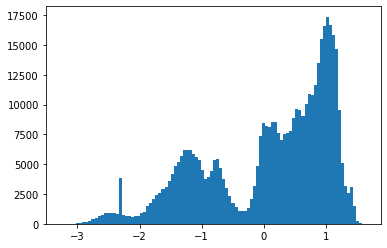

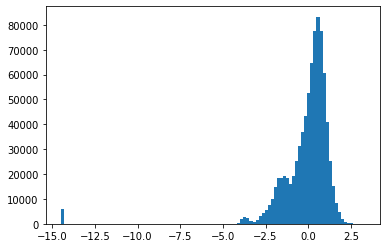

In [16]:
# get stats
all_shieldings = {}
for molecule in molecules:
    atomic_symbols = molecule.atomic_symbols
    perturbed_shieldings = molecule.perturbed_shieldings
    for i,symbol in enumerate(atomic_symbols):
        if symbol in relevant_elements:
            if symbol not in all_shieldings:
                all_shieldings[symbol] = []
            shieldings_list = all_shieldings[symbol]
            current_shieldings = shieldings_list.extend(perturbed_shieldings[:,i])
shieldingsC = all_shieldings["C"]
print(np.shape(shieldingsC))
print(np.mean(shieldingsC))
print(np.std(shieldingsC))
shieldingsH = all_shieldings["H"]
print(np.shape(shieldingsH))
print(np.mean(shieldingsH))
print(np.std(shieldingsH))
plt.hist(shieldingsC,bins=100)
plt.show()
plt.hist(shieldingsH,bins=100)
plt.show()

In [17]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_elements,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 4.0

In [18]:
def create_torch_dataset(molecules):
    dataset = []
    n_molecules = len(molecules)
    for i,molecule in enumerate(molecules):
        features = torch.tensor(molecule.features, dtype=torch.float64)
        features.to(device)
        weights = torch.tensor(molecule.weights, dtype=torch.float64)
        weights.to(device)
        n_to_save = len(molecule.perturbed_geometries)
        for j in range(n_to_save):
            if j == 0 or (j+1) % 50 == 0 or j == n_to_save - 1:
                print(f"Processing geometry {j+1:5d}/{n_to_save:5d} for molecule {molecule.name:5s} ({i+1:5d}/{n_molecules:5d})...           ", end='\r', flush=True)
            g = torch.tensor(molecule.perturbed_geometries[j,:,:], dtype=torch.float64)
            s = torch.tensor(molecule.perturbed_shieldings[j], dtype=torch.float64).unsqueeze(-1)  # [1,N]
            data = dh.DataNeighbors(x=features, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                    self_interaction=True, name=molecule.name,
                                    weights=weights, y=s, Rs_out = Rs_out)
            dataset.append(data)
    print("\ndone!")
    return dataset


In [19]:
# split into train and test molecules
# then preprocess the neighbor data
training_molecules, testing_molecules = train_test_split(molecules, train_size=900, test_size=100, random_state=1)
training_dataset = create_torch_dataset(training_molecules)
testing_dataset = create_torch_dataset(testing_molecules)

Processing geometry   100/  100 for molecule 000041 (  900/  900)...           
done!
Processing geometry   100/  100 for molecule 000212 (  100/  100)...           
done!


In [20]:
# mean-squared loss
def loss_function(output, data):
    predictions = output
    observations = data.y
    weights = data.weights
    normalization = weights.sum()
    residuals = (predictions-observations)
    loss = residuals.square() * weights
    loss = loss.sum() / normalization
    loss = loss.pow(0.5)
    return loss, residuals

In [55]:
# define the neural network architecture
#     def __init__(self, Rs_in, muls, Rs_out, lmaxes, #layers=3,
#                  max_radius=1.0, number_of_basis=3, radial_layers=3,
#                  feature_product=False, kernel=Kernel, convolution=Convolution):
# def model_from_kwargs(model_kwargs):
#     d = deepcopy(model_kwargs)
#     Network = eval(d.pop('network'))
#     Conv = eval(d.pop('conv'))
#     return Network(convolution=Conv, **d)
model_kwargs = {
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'muls': [3,3,3],            # how many copies of each tensor at each layer
    'lmaxes': [2,2,1],          # maximum angular momentum
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 30,     # number of Gaussians in radial kernel?
}
model = VariableParityNetwork(convolution=Convolution, **model_kwargs)
model.to(device);

In [48]:
# # define the neural network architecture
# model_kwargs = {
#     'network': 'GatedConvParityNetwork', 
#     'conv': 'Convolution',
#     'Rs_in': Rs_in,            # shape of inputs
#     'Rs_out': Rs_out,          # shape of outputs
#     'mul': 3,                 # how many copies of each tensor at each layer
#     'lmax': 2,                 # maximum angular momentum
#     'layers': 3,               # number of layers
#     'max_radius': max_radius,  # radial kernel will extend out this far
#     'number_of_basis': 10,     # number of Gaussians in radial kernel?
# }
# model = model_from_kwargs(model_kwargs)
# model.to(device);

In [49]:
# training parameters
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), learning_rate)
epochs = 100       
n_norm = 11           # n_norm is average number of convolution neighbors per atom
batch_size = 200

In [56]:
# prepare to train model
torch.cuda.empty_cache()

training_size = len(training_dataset)
n_training_batches = int(training_size / batch_size)
training_dataloader = tg.data.DataListLoader(training_dataset, batch_size=batch_size, shuffle=True)

testing_size = len(testing_dataset)
n_testing_batches = int(testing_size / batch_size)
testing_dataloader = tg.data.DataListLoader(testing_dataset, batch_size=batch_size, shuffle=False)

results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
history = []      # index is epoch, items are (train_loss, test_loss)

In [57]:
# train model
start_time = time.time()
for i in range(epochs):
    start_time = time.time()
    
    # training
    training_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(training_dataloader):
        # forward pass
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        loss, residuals = loss_function(output, data)
        
        # backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # update training loss
        temp_loss = loss.detach()
        training_loss_cum += loss.detach().pow(2)
        current_cum = np.sqrt(training_loss_cum.item() / (j+1))
        print(f"Iteration {i+1:<4d}    train {j+1:5d} / {n_training_batches:5d}  loss = {temp_loss.item():12.3f}    cum_loss = {current_cum:12.3f}            ", end="\r", flush=True)
        
    training_loss_cum = np.sqrt((training_loss_cum.item()/(j+1)))
    
    # testing
    testing_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(testing_dataloader):
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        
        with torch.no_grad():
            # run model
            output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)

            # compute MSE
            loss, residuals = loss_function(output,data)
            testing_loss_cum += loss.pow(2)
        print(f"Iteration {i+1:<4d}    test {j+1:5d} / {n_testing_batches:5d}  loss = {loss.item():12.3f}                                  ", end="\r", flush=True)
    
    testing_loss_cum = np.sqrt((testing_loss_cum.item()/(j+1)))
    end_time = time.time()
    elasped_time = end_time - start_time
    history.append((training_loss_cum, testing_loss_cum))
    print(f"Iteration {i+1:<4d}        training = {training_loss_cum.item():>12.3f}    testing = {testing_loss_cum.item():>12.3f}     elapsed = {elasped_time:7.2f} s                     ", end="\r", flush=True)
    print()
    #if i == 0 or (i+1) % 10 == 0:
    #    print()

Iteration 1           training =      133.167    testing =      126.898     elapsed =   78.88 s                     
Iteration 2           training =      133.167    testing =      126.898     elapsed =   79.22 s                     
Iteration 3           training =      133.167    testing =      126.898     elapsed =   79.25 s                     


KeyboardInterrupt: 

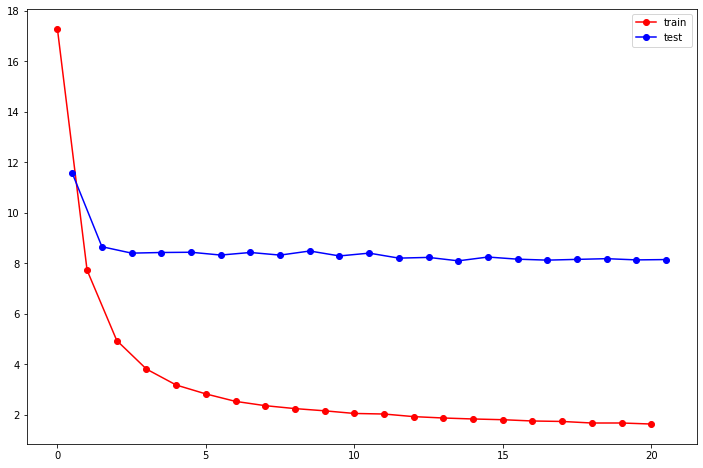

In [50]:
# plot learning curve
plt.figure(figsize=(12,8))
epoch = list(range(len(history)))
epoch = np.array(epoch)
epoch2 = epoch + 0.5
training_loss = [ training for training,testing in history ]
testing_loss = [ testing for training,testing in history ]
plt.plot(epoch, training_loss, "ro-", label="train")
plt.plot(epoch2, testing_loss, "bo-", label="test")
plt.legend(loc="best")
plt.show()

In [51]:
# test the model as it now
torch.cuda.empty_cache()
n_batches = math.ceil(testing_size / batch_size)
results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
start_time = time.time()

loss_cum = torch.tensor([0.]).to(device)
for j,data in enumerate(testing_dataloader):
    print(f"batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)
    with torch.no_grad():
        # run model
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        
        # compute MSE
        loss, residuals = loss_function(output,data)
        loss_cum += loss.pow(2)
        
        # rescale residuals back to ppm and store
        residuals = residuals.squeeze(-1).cpu().numpy()
        i=0
        for name in data.name:
            molecule = molecules_dict[name]
            n_atoms = molecule.n_atoms
            scaling_factors = molecule.scaling_factors
            if name not in results_dict:
                results_dict[name] = []
            subset = residuals[i:i+n_atoms] * scaling_factors[:,1]
            results_dict[name].append(subset)
            i += n_atoms
            
loss_cum = loss_cum/(j+1)
loss_cum = loss_cum.pow(0.5)
end_time = time.time()
elasped_time = end_time - start_time
print(f"\nOverall loss is {loss_cum.item():.6f}.  Evaluation took {elasped_time:.2f} s.")

batch    20 /    20
Overall loss is 8.073083.  Evaluation took 0.91 s.


In [52]:
# results_dict : molecule name -> residuals (n_examples,n_atoms)
# results_dict2 : site label -> residuals
results_dict2 = {}
all_residuals = {}  # element --> [residuals]
for name,results in results_dict.items():
    results = np.array(results).T
    molecule = molecules_dict[name]
    atomic_symbols = molecule.atomic_symbols
    for atomic_index,this_result in enumerate(results):
        element = atomic_symbols[atomic_index]
        if element not in relevant_elements:
            continue
        label = f"{name}_{element}{atomic_index+1}"
        results_dict2[label]=this_result
        if element not in all_residuals:
            all_residuals[element] = []
        all_residuals[element].extend(this_result)

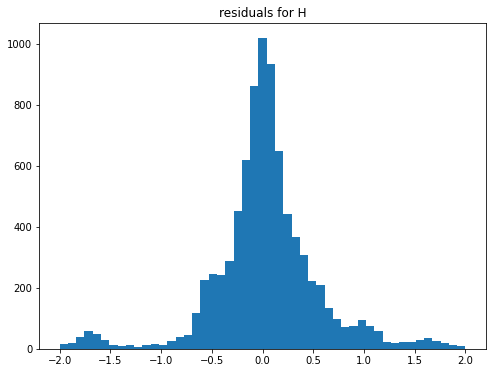

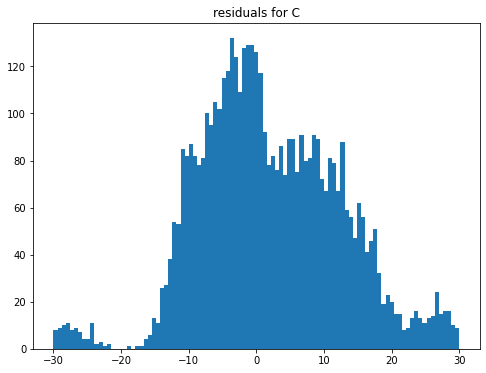

In [53]:
e="H"
bins = np.linspace(-2,2,50)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()
e="C"
bins = np.linspace(-30,30,100)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()

In [54]:
# get stats on everything
for e in relevant_elements:
    mean_error = np.mean(all_residuals[e])
    RMSE = np.sqrt(np.mean(np.square(all_residuals[e])))
    min_err = np.min(all_residuals[e])
    max_err = np.max(all_residuals[e])
    print(f"{e}:  mean ={mean_error:7.3f}  RMSE ={RMSE:7.3f}   range = {min_err:7.2f} to {max_err:7.2f}")

C:  mean =  1.288  RMSE = 13.949   range =  -45.08 to   44.05
H:  mean =  0.011  RMSE =  0.577   range =   -2.48 to    2.10


In [34]:
# summary stats
df = pd.DataFrame(results_dict2)
means = df.mean()
ranges = df.max()-df.min()
RMSEs = np.sqrt(df.pow(2).mean())
df = pd.concat([means,ranges,RMSEs], axis=1)
df.columns = ["mean","range","RMSE"]
df = df.round(2)
display(df)

,mean,range,RMSE
520_C2,-7.98,21.18,8.53
520_C3,13.45,15.79,13.76
520_C4,11.61,9.52,11.79
520_C5,11.51,11.70,11.75
520_C6,12.78,13.59,13.12
...,...,...,...
5820_H11,0.28,0.52,0.30
5820_H12,0.37,0.51,0.39
5820_H13,-0.15,0.39,0.17
5820_H14,0.22,0.27,0.23


In [ ]:
def save_model(model_kwargs, model, filename, optimizer=None):
    model_dict = {
        'state_dict': model.state_dict(),
        'model_kwargs': model_kwargs
    }
    if optimizer is not None:
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
    torch.save(model_dict, filename)

In [ ]:
save_model(model_kwargs, model, "small-model2.torch", optimizer=opt)

In [ ]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 3,                 # how many copies of each tensor at each layer
    'lmax': 1,                 # maximum angular momentum
    'layers': 3,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 30,     # number of Gaussians in radial kernel?
}
model = model_from_kwargs(model_kwargs)
model.to(device);